In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import math
import json
import pandas as pd
import requests
from pandas import json_normalize
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
def Pitch(ax, height = 120,  width=80, line_color = "black", pitch_color = "white", mode = "full", pitch_linewidth = 1):

    def int_angles(radius, h, k, line_x):
        """
        Calculate the intersection angles of the arc above the D-boxes
        
        Parameters: 
            radius (float): Radius of the arc
            h(float): x coordinate of the centre of the arc
            k(float): y coordiante of the centre of the arc
            line_x(float): x coordinate of the D-box or the line to be intersected by the arc
      
        Returns: 
            theta1(float): First intersection angle
            theta2(float): Second intersection angle
        """
        y1 = math.sqrt(radius**2 - (line_x - h)**2) + k
        y2 = math.sqrt(radius**2 - (line_x - h)**2)*-1 + k
        y = (y1-y2)/2
        theta1 = math.degrees(math.asin(y/radius))
        theta2 = 360-theta1

        return theta1, theta2

    
    #Pitch Outline
    ax.plot([0,0],[0,width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([0,height],[width,width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([height,height],[width,0], color=line_color, linewidth = pitch_linewidth)
    ax.plot([height,0],[0,0], color=line_color, linewidth = pitch_linewidth)

    
    ##Halfway-line
    ax.plot([height/2, height/2],[0,width], color=line_color, linewidth = pitch_linewidth)

    #Left Penalty Area
    ax.plot([0,.15*height],[.225*width, .225*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.15*height, .15*height],[.225*width,0.775*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.15*height,0],[.775*width, .775*width], color=line_color, linewidth = pitch_linewidth)

    #Right Penalty Area
    ax.plot([.85*height,height],[.15*height, .15*height], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.85*height,.85*height],[.15*height, .775*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.85*height,height],[.775*width, .775*width], color=line_color, linewidth = pitch_linewidth)
    
    #6-yard box left
    ax.plot([0,.05*height],[.375*width, .375*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.05*height, .05*height],[.375*width,width - .375*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([0,.05*height],[.625*width, .625*width ], color=line_color, linewidth = pitch_linewidth)    

    #6-yard box right
    ax.plot([.95*height,height],[.375*width, .375*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.95*height,114],[.375*width, .625*width], color=line_color, linewidth = pitch_linewidth)
    ax.plot([.95*height,height],[.625*width, .625*width], color=line_color, linewidth = pitch_linewidth)

      
        #Prepare Circles
    centreCircle = plt.Circle((height/2, width/2),.076*height,color=line_color,fill=False, zorder=5)
    centreSpot = plt.Circle((height/2, width/2),0.8,color=line_color)
    leftPenSpot = plt.Circle((.1*height,40),0.8,color=line_color)
    rightPenSpot = plt.Circle((.9*height,40),0.8,color=line_color)

                
        #Prepare Arcs
    theta1, theta2 = int_angles(radius = height/12,
                                h = .1*height,
                                k= width/2,
                                line_x = .15*height)

    
    leftArc = Arc((.1*height,40),
                              height=0.15*height,
                              width=0.15*height,
                              angle=0,
                              theta1=theta2,
                              theta2=theta1,
                              color=line_color,
                              zorder=5)
    
    theta1, theta2 = int_angles(radius = height/12,
                                h = .9*height,
                                k= width/2,
                                line_x = .85*height)
    
    rightArc = Arc((.9*height,40),
                               height=0.15*height,
                               width=0.15*height,
                               angle=180,
                               theta1=theta2,
                               theta2=theta1,
                               color=line_color,
                               zorder=5)

        ##Add corner arcs
    left_bottom = Arc((0,0),
                  height=.05*height,
                  width=0.05*height,
                  angle=270,
                  theta1=90,
                  theta2=180,
                  color=line_color,
                  zorder=5)

    left_top = Arc((0,width),
                  height=.05*height,
                  width=0.05*height,
                  angle=0,
                  theta1=270,
                  theta2=0,
                  color=line_color,
                   zorder=5)

    right_bottom = Arc((height, 0),
                  height=.05*height,
                  width=0.05*height,
                  angle=0,
                  theta1=90,
                  theta2=180,
                  color=line_color,
                   zorder=5    )
    
    right_top = Arc((height, width),
                  height=.05*height,
                  width=0.05*height,
                  angle=90,
                  theta1=90,
                  theta2=180,
                  color=line_color,
                   zorder=5 )    

    
        #Goals
    ax.plot([0,0],[.45*width, .55*width],color=line_color, linewidth = pitch_linewidth*4)
    ax.plot([height, height],[.45*width, .55*width],color=line_color, linewidth = pitch_linewidth*4)

        #Add patches
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    if mode == "full":
        ax.add_patch(left_bottom)
        ax.add_patch(left_top)
        ax.add_patch(right_bottom)
        ax.add_patch(right_top)

    ax.set_aspect("equal")
    ax.axis("off")

    return ax

In [3]:
class Player:
    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):
        player_pass_df = df.query(
            "(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
        self.x, self.y = np.mean(player_pass_df['location'].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)


In [4]:
def load_file():
    with open(f"../../../data/statsbomb360/events/3788747.json", "r", encoding="utf-8") as f:
        match_dict = json.load(f)
        df = json_normalize(match_dict, sep="_")
        df = df.query("location == location")
        df[['x', 'y']] = pd.DataFrame(df.location.values.tolist(), index=df.index)
        df['y'] = 80 - df['y']
        df['location'] = df[['x', 'y']].apply(list, axis=1)

    return match_dict, df

In [5]:


def get_starters(match_dict, side="home"):
    """ """
    lineups = match_dict[0]["tactics"]["lineup"] if side == "home" else match_dict[1]["tactics"]["lineup"]
    return lineups

In [6]:
def draw_plot(side: str, save: bool = False, file_path: str = None):
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

    match_id = "3788747"
    side = side
    color = "red" if side == "home" else "orange"
    min_pass_count = 2  # Minimum number of passes for a link to be plotted

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = Pitch(ax)

    # Calling the functions and getting the data
    match_dict, df = load_file()
    lineups = get_starters(match_dict, side=side)

    ###
    side_dict = {"home": match_dict[0]["team"]["name"],
                "away": match_dict[1]["team"]["name"]}  # For easy lookup for the title and so on

    player_objs_dict = {}
    starters = []

    for player in lineups:
        starters.append(player["player"]["name"])  # To remove all substitutes from our final grouped_df
        p = Player(player, df)  # Calling the Player class
        player_objs_dict.update({player["player"]["name"]: p})  # For lookup during plotting the grouped_df

    #Cleaning the grouped df

    total_pass_df = df.query(
        f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &" \
        f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
    total_pass_df = total_pass_df.groupby(["player_name", "pass_recipient_name"]).size().reset_index(name="count")
    total_pass_df = total_pass_df.query(
        " (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) ")

    arrow_shift = 1  # Units by which the arrow moves from its original position
    shrink_val = 1.5  # Units by which the arrow is shortened from the end_points

    # Visualising the passmap

    for row in total_pass_df.itertuples():
        link = row[3]  # For the arrow-width and the alpha
        passer = player_objs_dict[row[1]]
        receiver = player_objs_dict[row[2]]

        alpha = link / 15
        if alpha > 1:
            alpha = 1

        if abs(receiver.x - passer.x) > abs(receiver.y - passer.y):
            if receiver.id > passer.id:
                ax.annotate("", xy=(receiver.x, receiver.y + arrow_shift), xytext=(passer.x, passer.y + arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val,
                                            lw=link * 0.12, alpha=alpha))

            elif passer.id > receiver.id:
                ax.annotate("", xy=(receiver.x, receiver.y - arrow_shift), xytext=(passer.x, passer.y - arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val,
                                            lw=link * 0.12, alpha=alpha))

        elif abs(receiver.x - passer.x) <= abs(receiver.y - passer.y):

            if receiver.id > passer.id:
                ax.annotate("", xy=(receiver.x + arrow_shift, receiver.y), xytext=(passer.x + arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val,
                                            lw=link * 0.12, alpha=alpha))

            elif passer.id > receiver.id:
                ax.annotate("", xy=(receiver.x - arrow_shift, receiver.y), xytext=(passer.x - arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val,
                                            lw=link * 0.12, alpha=alpha))


    for name, player in player_objs_dict.items():
        ax.scatter(player.x, player.y, s=player.n_passes_completed * 1.3, color=color, zorder=4)
        ax.text(player.x, player.y + 2 if player.y > 40 else player.y - 2, s=player.name.split(" ")[-1], rotation=270,
                va="top" if player.y < 40 else "bottom", size=6.5, fontweight="book", zorder=7, color=color)

    ax.text(124, 80, f"{side_dict[side]}", size=12, fontweight="demibold", rotation=270, color=color, va="top")
    ax.text(122, 80, f"{side_dict['home']} vs {side_dict['away']}", size=8, fontweight="demibold", rotation=270, va="top")

    fig.tight_layout()
    
    if save:
        plt.savefig(file_path, dpi=300)
    
    plt.show()

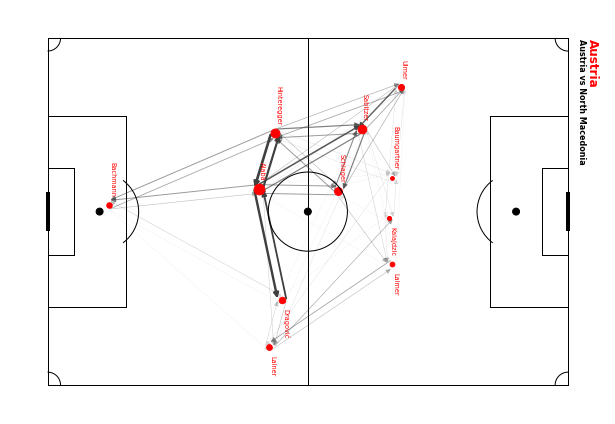

In [7]:
import os

path = '../../../upload/passing/passing_networks_austria.png'

draw_plot('home', save=True,
          file_path=path)


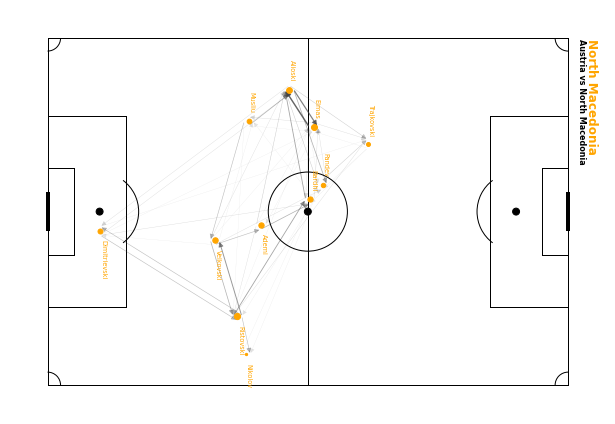

In [8]:
draw_plot('away', save=True, file_path='../../../upload/passing/passing_networks_north_macedonia.png')
